In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model_name = "Qwen/Qwen3-0.6B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", device_map="cuda")

# Ensure pad token is set (important for batch training)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id

/home/bmartins/anaconda3/envs/llm-scratch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 23.43 GiB of which 6.06 MiB is free. Process 671198 has 22.04 GiB memory in use. Including non-PyTorch memory, this process has 1.36 GiB memory in use. Of the allocated memory 1.11 GiB is allocated by PyTorch, and 4.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Testing the base model 

In [ ]:
content = "how are you?"
messages = [{"role": "user", "content": content}]
prompt_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, enable_thinking=False)
print(f"prompt text is {prompt_text}")
inputs = tokenizer(prompt_text, return_tensors="pt").to(model.device)
output_ids = model.generate(**inputs, max_new_tokens=50)
baseline_answer = tokenizer.decode(output_ids[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
print(f"model output: \n {baseline_answer}")

prompt text is <|im_start|>user
how are you?<|im_end|>
<|im_start|>assistant
<think>

</think>


model output: 
 Hello! How can I help you today?


In [ ]:
inputs['input_ids'].shape[1]

16

In [ ]:
output_ids[0]

tensor([151644,    872,    198,   5158,    525,    498,     30, 151645,    198,
        151644,  77091,    198, 151667,    271, 151668,    271,   9707,      0,
          2585,    646,    358,   1492,    498,   3351,     30, 151645],
       device='cuda:0')

In [ ]:
output_ids[0][inputs['input_ids'].shape[1]:]

tensor([  9707,      0,   2585,    646,    358,   1492,    498,   3351,     30,
        151645], device='cuda:0')

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
prompt_len = inputs['input_ids'].shape[1]
print("{:<10}".format("tok_id"), "{:<10}".format("sub"), "{:<10}".format("repr(txt)"))

gen_ids = output_ids[0, prompt_len:]
for tok_id in gen_ids.tolist():
    sub = tokenizer.convert_ids_to_tokens(tok_id)
    txt = tokenizer.decode([tok_id], skip_special_tokens=False, clean_up_tokenization_spaces=False)
    print("{:<10}".format(tok_id), "{:<10}".format(sub), "{:<10}".format(repr(txt)))

tok_id     sub        repr(txt) 
9707       Hello      'Hello'   
0          !          '!'       
2585       ĠHow       ' How'    
646        Ġcan       ' can'    
358        ĠI         ' I'      
1492       Ġhelp      ' help'   
498        Ġyou       ' you'    
3351       Ġtoday     ' today'  
30         ?          '?'       
151645     <|im_end|> '<|im_end|>'


### Test the base model

In [ ]:
# SKIP THIS CELL - it overwrites the instruction-tuned model with the base model
# The base model is not designed for instruction following

# model_name = "Qwen/Qwen3-0.6B-Base"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", device_map="cuda")

In [ ]:
content = "How are you"
messages = [{"role": "user", "content": content}]

prompt_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, enable_thinking=False)
print("prompt text is: %s" % prompt_text)

inputs = tokenizer(prompt_text, return_tensors="pt").to(model.device)
# Generate a response
output_ids = model.generate(**inputs, max_new_tokens=50)
baseline_answer = tokenizer.decode(output_ids[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
print("models output: %s" % baseline_answer)

prompt text is: <|im_start|>user
How are you<|im_end|>
<|im_start|>assistant
<think>

</think>




models output: Hello! I'm a language model, and I'm here to help with anything you need! What can I do for you?


### Preparing the fine tuning dataset

In [ ]:
from datasets import load_dataset
import torch 
from torch.nn.utils.rnn import pad_sequence

# Add download_mode to force fresh download and avoid cache issues
raw_ds = load_dataset("tatsu-lab/alpaca", split="train[:2000]", download_mode="force_redownload")

def format_example(example):
    if example['input']:
        user_text = f"{example['instruction']}\n{example['input']}"
    else:
        user_text = example['instruction']
    prompt = (
        f"<[im_start]>user\n{user_text}<[im_end]>\n"
        f"<[im_start]>assistant\n"
    )
    full_text = prompt + example["output"] + "<[im_end]>"
    prompt_len = len(tokenizer(prompt)["input_ids"])
    return {"prompt": prompt, "full_text": full_text, "prompt_len": prompt_len}

chat_ds = raw_ds.map(format_example, remove_columns=raw_ds.column_names)

Map: 100%|██████████| 2000/2000 [00:00<00:00, 12409.33 examples/s]


In [ ]:
chat_ds

Dataset({
    features: ['prompt', 'full_text', 'prompt_len'],
    num_rows: 2000
})

In [ ]:
def tokenize_func(ex):
    tok = tokenizer(ex["full_text"], truncation=True)
    tok["prompt_len"] = ex["prompt_len"]
    return tok

In [ ]:
tok_ds = chat_ds.map(tokenize_func, remove_columns=chat_ds.column_names)

Map:  40%|████      | 802/2000 [00:00<00:00, 7995.19 examples/s]

Map: 100%|██████████| 2000/2000 [00:00<00:00, 7550.93 examples/s]


In [ ]:
for raw_example, chat_example, tok_example in zip(raw_ds, chat_ds, tok_ds):
    print("raw_example:")
    print("instruction: %s" % raw_example["instruction"])
    print("input: %s" % raw_example["input"])
    print("output: %s" % raw_example["output"])
    print()
    print("chat_example:")
    print("prompt: %s" % chat_example["prompt"])
    print("full_text: %s" % chat_example["full_text"])
    print()
    print("tok_example:")
    print("input_ids: %s" % tok_example["input_ids"])
    print("prompt_len: %s" % tok_example["prompt_len"])
    print()
    break

raw_example:
instruction: Give three tips for staying healthy.
input: 
output: 1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. 
2. Exercise regularly to keep your body active and strong. 
3. Get enough sleep and maintain a consistent sleep schedule.

chat_example:
prompt: <[im_start]>user
Give three tips for staying healthy.<[im_end]>
<[im_start]>assistant

full_text: <[im_start]>user
Give three tips for staying healthy.<[im_end]>
<[im_start]>assistant
1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. 
2. Exercise regularly to keep your body active and strong. 
3. Get enough sleep and maintain a consistent sleep schedule.<[im_end]>

tok_example:
input_ids: [66746, 318, 4906, 25669, 872, 198, 35127, 2326, 10414, 369, 19429, 9314, 15757, 58, 318, 6213, 64077, 66746, 318, 4906, 25669, 77091, 198, 16, 5142, 266, 264, 23831, 9968, 323, 1281, 2704, 311, 2924, 11260, 315, 25322, 323, 23880, 13, 715, 17, 13, 32818, 15502, 311, 2506,

In [ ]:
import torch 
from torch.nn.utils.rnn import pad_sequence

class SFTDataCollator:
    def __call__(self, batch):
        # convert list of tokenized samples to padded tensor batch 
        input_ids_list = [torch.tensor(b["input_ids"]) for b in batch]
        input_ids = torch.nn.utils.rnn.pad_sequence(input_ids_list, batch_first=True, padding_value=tokenizer.pad_token_id)
        # Attention mask: 1 for real tokens, 0 for pad 
        attention_mask = (input_ids != tokenizer.pad_token_id).long()
        # create labels (copy of input_ids)
        labels = input_ids.clone()
        # mask out prompt part (all tokens up to and including "### Response:\n")
        for i, b in enumerate(batch):
            prompt_len = b['prompt_len'] # length of prompt in tokens 
            labels[i, :prompt_len] = -100 # ignore prompt tokens in loss 
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

In [ ]:
data_collator = SFTDataCollator()

### Training the model with SFT 

In [ ]:
from transformers import TrainerCallback
import math

class PerplexityCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                logs["train_perplexity"] = math.exp(logs["loss"])
            if "eval_loss" in logs:
                logs["eval_perplexity"] = math.exp(logs["eval_loss"])

In [ ]:
# Split dataset into train and evaluation sets
train_test_split = tok_ds.train_test_split(test_size=0.1, seed=42)
train_ds = train_test_split["train"]
eval_ds = train_test_split["test"]

print(f"Training samples: {len(train_ds)}")
print(f"Evaluation samples: {len(eval_ds)}")

In [ ]:
from transformers import TrainingArguments, Trainer 

training_args = TrainingArguments(
    output_dir="qwen_sft_demo",
    overwrite_output_dir=True, 
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,  # Added for evaluation
    eval_strategy="steps",  # Evaluate periodically during training
    eval_steps=100,  # Evaluate every 100 steps
    gradient_accumulation_steps=1,
    learning_rate=2e-5,
    warmup_steps=100,
    logging_steps=20,
    save_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,  # Load best model based on eval loss
    metric_for_best_model="eval_loss",  # Use eval loss to determine best model
    report_to=[],
    bf16=True,
    disable_tqdm=False,
    remove_unused_columns=False
)

In [ ]:
trainer = Trainer(
    model=model,
    train_dataset=train_ds,  # Use train split instead of full dataset
    eval_dataset=eval_ds,  # Add evaluation dataset
    data_collator=data_collator,
    args=training_args,
    callbacks=[PerplexityCallback()]  # Add perplexity tracking
)

In [ ]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=3000, training_loss=0.8324340136845907, metrics={'train_runtime': 328.7333, 'train_samples_per_second': 18.252, 'train_steps_per_second': 9.126, 'total_flos': 1845623829823488.0, 'train_loss': 0.8324340136845907, 'epoch': 3.0})

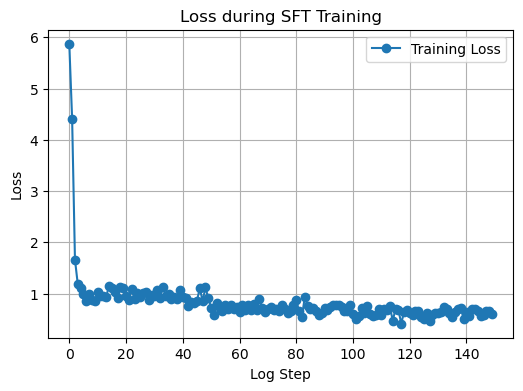

In [ ]:
import matplotlib.pyplot as plt 

loss_history = [log["loss"] for log in trainer.state.log_history if "loss" in log]
plt.figure(figsize=(6,4))
plt.plot(range(len(loss_history)), loss_history, marker='o', label="Training Loss")
plt.xlabel("Log Step")
plt.ylabel("Loss")
plt.title("Loss during SFT Training")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

# Extract training and evaluation perplexity
train_perplexity = [log.get("train_perplexity") for log in trainer.state.log_history if "train_perplexity" in log]
eval_perplexity = [log.get("eval_perplexity") for log in trainer.state.log_history if "eval_perplexity" in log]
eval_steps = [log["step"] for log in trainer.state.log_history if "eval_perplexity" in log]

# Plot perplexity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training perplexity over time
ax1.plot(range(len(train_perplexity)), train_perplexity, marker='o', label="Training Perplexity", alpha=0.7)
ax1.set_xlabel("Log Step")
ax1.set_ylabel("Perplexity")
ax1.set_title("Training Perplexity")
ax1.legend()
ax1.grid(True)

# Plot 2: Training vs Evaluation perplexity
ax2.plot(range(len(train_perplexity)), train_perplexity, label="Train Perplexity", alpha=0.7)
if eval_perplexity:
    # Map eval steps to train step indices for alignment
    train_steps = [log["step"] for log in trainer.state.log_history if "train_perplexity" in log]
    eval_step_indices = [train_steps.index(step) if step in train_steps else None for step in eval_steps]
    eval_step_indices = [i for i in eval_step_indices if i is not None]
    eval_perplexity_filtered = [eval_perplexity[i] for i in range(len(eval_step_indices))]
    ax2.plot(eval_step_indices, eval_perplexity_filtered, label="Eval Perplexity", marker='o', color='orange')
ax2.set_xlabel("Log Step")
ax2.set_ylabel("Perplexity")
ax2.set_title("Training vs Evaluation Perplexity")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
if train_perplexity:
    print(f"\nFinal Training Perplexity: {train_perplexity[-1]:.4f}")
if eval_perplexity:
    print(f"Final Evaluation Perplexity: {eval_perplexity[-1]:.4f}")

### Final test

In [ ]:
content = "How are you?"
messages = [{"role": "user", "content": content}]
prompt_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True, enable_thinking=False)


In [ ]:
inputs = tokenizer(prompt_text, return_tensors="pt").to(model.device)

In [ ]:
output_ids = model.generate(**inputs, max_new_tokens=50)
baseline_answer = tokenizer.decode(output_ids[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
print(f'Model output: {baseline_answer}')

Model output: I'm just a virtual assistant, but I'm here to help! How can I assist you?


### Evaluate 